# 階段昇降の角運動解析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lpf
import integral

## １．２つのデータフレームを時刻でマージする

◼️大腿に装着したセンサのデータを`df1`，下腿に装着したセンサのデータを`df2`というデータフレームオブジェクトに読み込む：

In [2]:
df1 = pd.read_csv("sakamoto_daitai.csv", header=None, 
                 names=['item', 'time', 'a1_x', 'a1_y', 'a1_z', 'u1_x', 'u1_y','u1_z'])
df2 = pd.read_csv("sakamoto_katai.csv", header=None, 
                 names=['item', 'time', 'a2_x', 'a2_y', 'a2_z', 'u2_x', 'u2_y','u2_z'])

> 項目記号の先頭文字`a`と`u`はそれぞれ，加速度と角速度を示し，それらの後ろの番号`1`と`2`はそれぞれ，大腿を下腿を示す。また，記号の`_x`, `_y`および`_z`はそれぞれ，x成分，y成分およびz成分を示す。

◼️`df1`と`df2`の最初のレコードを表示する：

In [3]:
df1.head()

,item,time,a1_x,a1_y,a1_z,u1_x,u1_y,u1_z
0,ags,53694657,9726,868,-1220,257,14,79
1,ags,53694658,9743,841,-1225,282,2,73
2,ags,53694659,9767,854,-1229,269,14,55
3,ags,53694660,9738,876,-1183,239,8,79
4,ags,53694661,9767,890,-1159,221,2,73


In [4]:
df2.head()

,item,time,a2_x,a2_y,a2_z,u2_x,u2_y,u2_z
0,ags,53694747,9780,1220,420,94,58,-246
1,ags,53694748,9793,1191,413,106,89,-240
2,ags,53694749,9780,1194,364,112,64,-222
3,ags,53694750,9756,1201,430,112,46,-234
4,ags,53694751,9751,1164,369,118,52,-246


> データフレーム`df1`, `df2`の`time`を見てみよう。
>>この時刻は1日の最初を0時0分0.000秒を0として，1ms単位でその日の時刻を表した整数である。したがって，例えば`df1`の`time`の`53694657`は14時54分54.657秒，`df2`の`time`の`53694747`は14時54分54.747秒ということになる。

> あれれ？パソコンで２つのセンサを同期させたはずなのに，計測開始時刻が異なってるじゃないか！ そうなんだ，パソコンでセンサを同期しても，どうしても0.1秒のオーダーでデータを**取り損ねてしまう**んだ。ただし，時刻自体は**パソコンの時刻に合っている**。したがって，同期させた２つのセンサでデータ分析をする場合，計測時刻を合わせる必要がある。これをする手っ取り早い方法が，２つのデータフレームを，時刻をキーとして，マージ（統合）することだ。

****
### 【公式1】データフレームのマージ（教科書には載っていない）
```
pd.merge(df_1, df_2, ..., df_i, ..., df_n, on=['key1','key2', ...] )
```
**共通の項目**をもつ$n$個のデータフレーム，`df1`, `df2`, ..., `dfn`を`on=`の右辺で指定された**リスト内のキー項目(群)**でマージする。  

例えば，`on=`の右辺のリスト内の項目の１つが`'A'`であり，データフレーム`df_i`の項目`'A'`のデータの集合を$A_i$とする。その場合上記コマンドを実行すると，**$A_1 \cap A_2 \cap ... \cap A_i \cap ... \cap A_n$となるレコードのみを残し（そうならないレコードは削除され）**，共通の項目`A`としてn個のデータフレームを結合する。

※）共通の項目が１つの場合は，`on='key'`などとできる。
****

◼️`df1`と`df2`を，項目`'item'`と`'time'`でマージしてデータフレームオブジェクト`df`に格納し，`df`の最初と最後のレコードを表示してみる：

In [5]:
df = pd.merge(df1, df2, on=['item', 'time'])   #df1とdf2を項目'item'と'time'でマージ

In [6]:
df.head()    #dfの最初の部分の表示

,item,time,a1_x,a1_y,a1_z,u1_x,u1_y,u1_z,a2_x,a2_y,a2_z,u2_x,u2_y,u2_z
0,ags,53694747,9662,854,-1227,87,21,273,9780,1220,420,94,58,-246
1,ags,53694748,9657,839,-1171,74,21,243,9793,1191,413,106,89,-240
2,ags,53694749,9711,900,-1195,62,21,219,9780,1194,364,112,64,-222
3,ags,53694750,9726,824,-1261,32,33,267,9756,1201,430,112,46,-234
4,ags,53694751,9718,773,-1229,1,39,292,9751,1164,369,118,52,-246


In [7]:
df.tail()    #dfの最後に部分の表示

,item,time,a1_x,a1_y,a1_z,u1_x,u1_y,u1_z,a2_x,a2_y,a2_z,u2_x,u2_y,u2_z
98928,ags,53793675,9650,1168,-1430,-260,-10,-183,9653,1372,171,-88,40,118
98929,ags,53793676,9684,1161,-1537,-266,2,-165,9729,1338,176,-94,46,131
98930,ags,53793677,9706,1134,-1561,-284,14,-177,9761,1360,162,-88,46,137
98931,ags,53793678,9618,1129,-1437,-291,2,-146,9688,1345,110,-100,28,137
98932,ags,53793679,9633,1083,-1466,-297,33,-159,9636,1335,201,-106,16,131


> 計測時刻（およびitem）が一致するところを残し，データフレームが１つに統合（マージ）された。

## ２．角速度の平滑化

◼️といあえず，大腿と下腿の矢状面に垂直な角速度（z成分）をプロットしよう。２つのセンサを右脚の外側に，z軸が矢状面に対して垂直右方向につけたとき，**角速度の正負はどのような状態なのかを考えよ：**

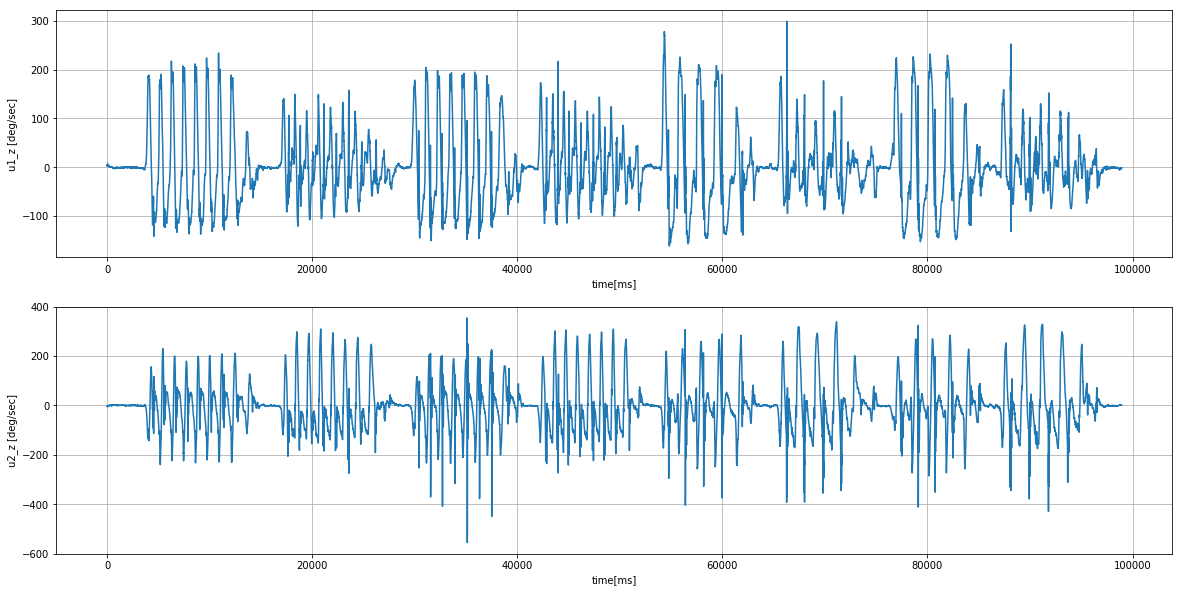

In [8]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(df['u1_z']/100)
plt.xlabel('time[ms]')
plt.ylabel(f'u1_z [deg/sec]')
plt.grid()   #プロット領域にグリッドをつける

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(df['u2_z']/100)
plt.xlabel('time[ms]')
plt.ylabel('u2_z [deg/sec]')
plt.grid()

> 両グラフのそれぞれの８つの波の塊のうちの最初の４つは通常に階段降昇を行い，最後の４つは１段飛ばしで階段降昇を行っている。

◼️50Hzのローパスフィルタでノイズとバイアス除去を行っておこう：
> 以前のローパスフィルタモジュールを汎用性をもたせるように改良した。このフォルダのモジュールを使ってくたまえ。なお，ローパスフィルタ関数のマニュアルは，`lpf.lpfilter?` を実行すれば確かめられる。

In [9]:
u1_z = lpf.lpfilter(df['u1_z']/100, 50)   #大腿角速度z成分
u2_z = lpf.lpfilter(df['u2_z']/100, 50)   #下腿角速度z成分

◼️`u1_z`, `u2_z`をプロットする：

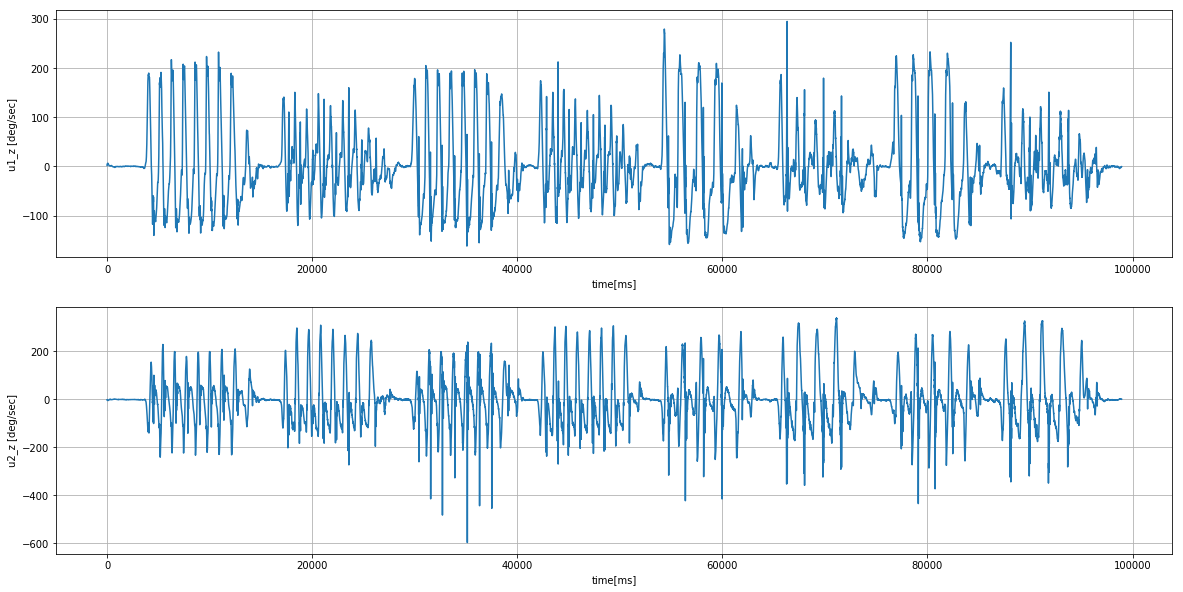

In [10]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(u1_z)
plt.xlabel('time[ms]')
plt.ylabel(f'u1_z [deg/sec]')
plt.grid()   #プロット領域にグリッドをつける

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(u2_z)
plt.xlabel('time[ms]')
plt.ylabel('u2_z [deg/sec]')
plt.grid()

◼️フィルタなしとあまり変化はないようだが，短い時間間隔（特に初期域）見ればよくわかる：

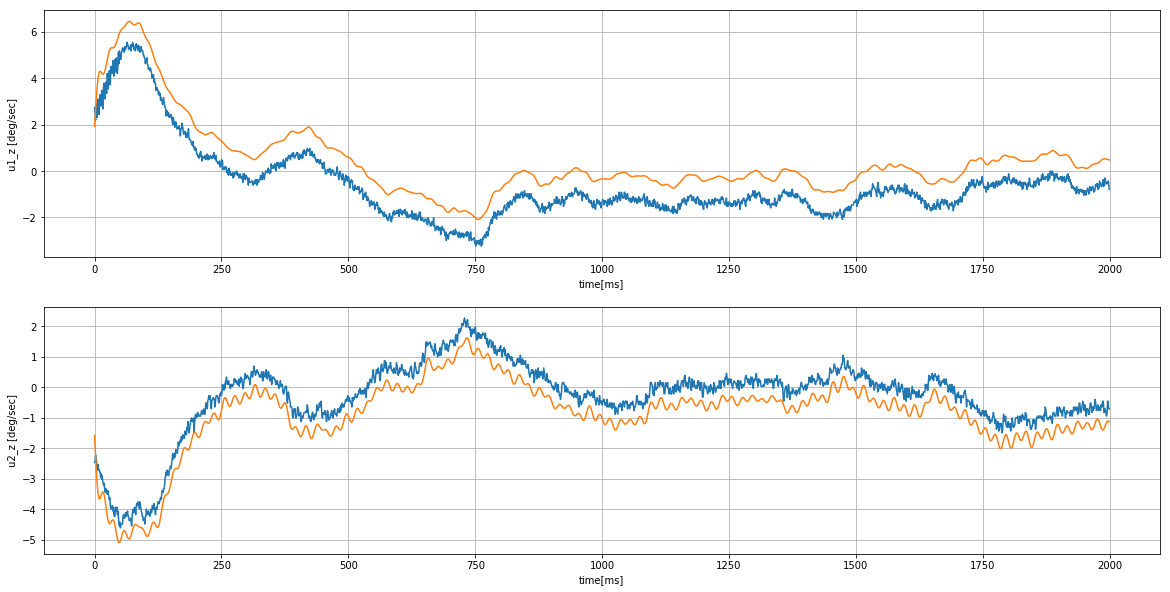

In [11]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
plt.plot(np.array(df['u1_z']/100)[:2000])
plt.plot(u1_z[:2000])
plt.xlabel('time[ms]')
plt.ylabel(f'u1_z [deg/sec]')
plt.grid()   #プロット領域にグリッドをつける

plt.subplot(2, 1, 2)
plt.plot(np.array(df['u2_z']/100)[:2000])
plt.plot(u2_z[:2000])
plt.xlabel('time[ms]')
plt.ylabel(f'u2_z [deg/sec]')
plt.grid()   #プロット領域にグリッドをつける

◼️上のグラフを見ると，（静止しているにも関わらず）1秒ちょっとまで変動がある。したがって，1.5秒(1500ms)までデータを取り除き，角速度データを再定義しておく：

In [12]:
u1_z = u1_z[1500:]   #大腿角速度z成分
u2_z = u2_z[1500:]   #下腿角速度z成分

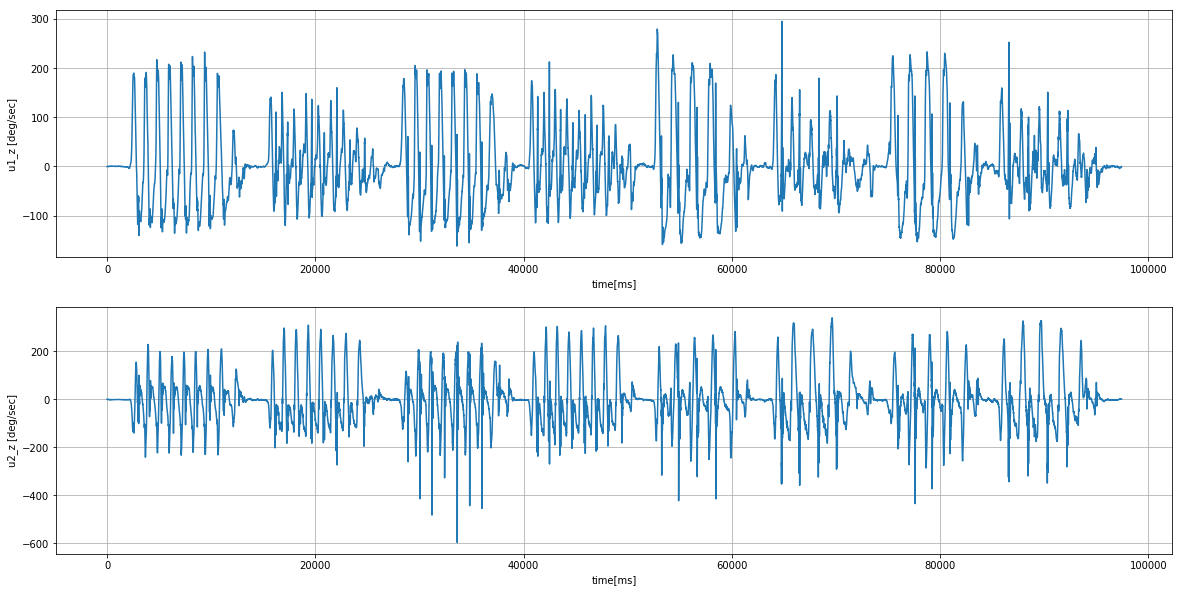

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(u1_z)
plt.xlabel('time[ms]')
plt.ylabel(f'u1_z [deg/sec]')
plt.grid()   #プロット領域にグリッドをつける

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(u2_z)
plt.xlabel('time[ms]')
plt.ylabel('u2_z [deg/sec]')
plt.grid()

◼️ちなみに最初の階段降り昇り状態をプロットしてみよう：

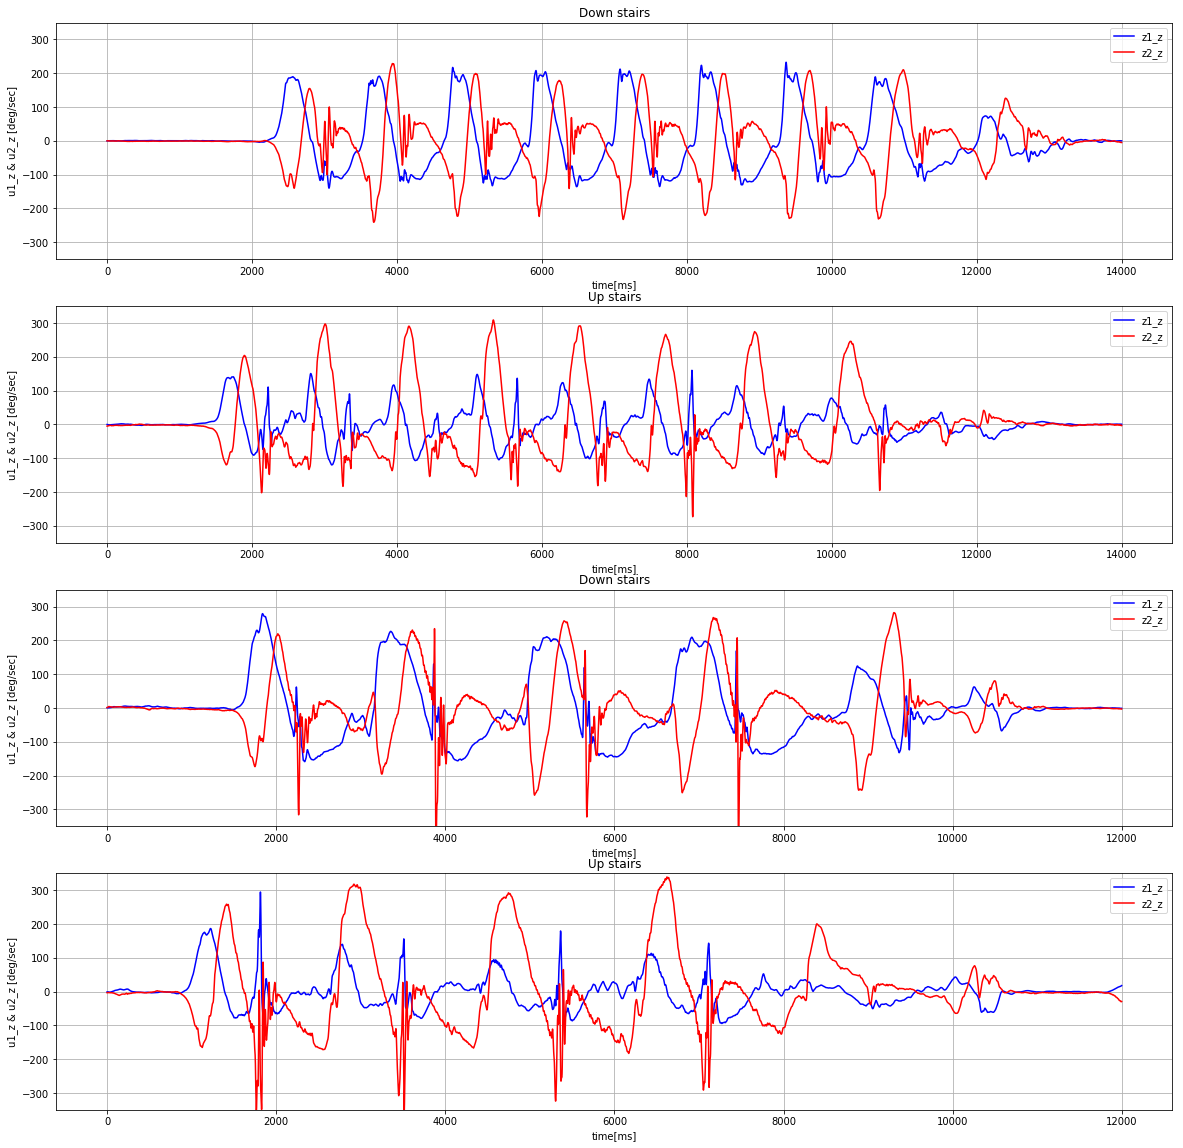

In [14]:
plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(u1_z[:14000], c='blue')
plt.plot(u2_z[:14000], c='red')
plt.title('Down stairs')
plt.xlabel('time[ms]')
plt.ylabel('u1_z & u2_z [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()   #プロット領域にグリッドをつける

plt.subplot(4, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(u1_z[14000:28000], c='blue')
plt.plot(u2_z[14000:28000], c='red')
plt.title('Up stairs')
plt.xlabel('time[ms]')
plt.ylabel('u1_z & u2_z [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()

plt.subplot(4, 1, 3)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(u1_z[51000:63000], c='blue')
plt.plot(u2_z[51000:63000], c='red')
plt.title('Down stairs')
plt.xlabel('time[ms]')
plt.ylabel('u1_z & u2_z [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()

plt.subplot(4, 1, 4)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(u1_z[63000:75000], c='blue')
plt.plot(u2_z[63000:75000], c='red')
plt.title('Up stairs')
plt.xlabel('time[ms]')
plt.ylabel('u1_z & u2_z [deg/sec]')
plt.ylim([-350, 350])
plt.legend(['z1_z', 'z2_z'])
plt.grid()

## ３．大腿と下腿の傾き角

◼️角速度を時間積分することによって，大腿と下腿の傾き角を求めよう。ここで，大腿または下腿が鉛直から後ろに傾いたときに正の角，前に傾いたときに負の角を与えることに注意しよう。
> ただし，**初期角を0degと仮定**したときという条件付きである。実際は，重力によって鉛直を決めてそれに対して初期角が何degになるかを求めなければならないが，座標変換等の複雑な数学が必要になるので，ここではそのことを考慮するのはやめておこう。  

数値積分は前の課題でプログラムしたので，アルゴリズムは解っていると思う。したがって，ここでの解析では，またこれをいちいちプログラムするのは面倒なので，`integral.py`というモジュールの中に関数を書いておいた。それを利用することにしよう。

***
### 【公式2】数値積分関数(台形則) 
```
integral.trapez(サンプルデータ配列, 初期値, 最初のindex, 最後のindex)
```
1000Hzの`サンプルデータ配列`を被積分関数配列として，配列の(任意の)`最初のindex`から(任意の)`最後のindex`まで数値積分した積分関数配列を返す。ただし，`初期値`は`最初のindex`のときに積分に与えられる値である。  
1. 台形則にもとづいた数値積分である。
2. 1000Hz未満のサンプルデータでは，`tau=1/周波数`オプションを用いればよい。詳しくは，マニュアル `integral.trapez?` を実行せよ。  
***

***
### 【公式2補】数値積分関数(シンプソン則) 
```
integral.simps(サンプルデータ配列, 初期値, 最初のindex, 最後のindex)
```
1000Hzの`サンプルデータ配列`を被積分関数配列として，配列の(任意の)`最初のindex`から(任意の)`最後のindex`まで数値積分した積分関数配列を返す。ただし，`初期値`は`最初のindex`のときに積分に与えられる値である。  
1. シンプソン則にもとづいた数値積分である。
2. 1000Hz未満のサンプルデータでは，`tau=1/周波数`オプションを用いればよい。詳しくは，マニュアル `integral.simps?` を実行せよ。
3. 公式2の台形則より精度が高い（積分誤差が少ない）が，計算に時間を要する。
***

◼️大腿の傾き角を`alpha`, 下腿の傾き角を`beta`とすると，`alpha`, `beta`は公式2を用いて次のように算出される：

In [15]:
alpha = integral.trapez(u1_z, 0, 0, len(u1_z)-1)
beta = integral.trapez(u2_z, 0, 0, len(u2_z)-1)

◼️`alpha`, `beta`をプロットすると：

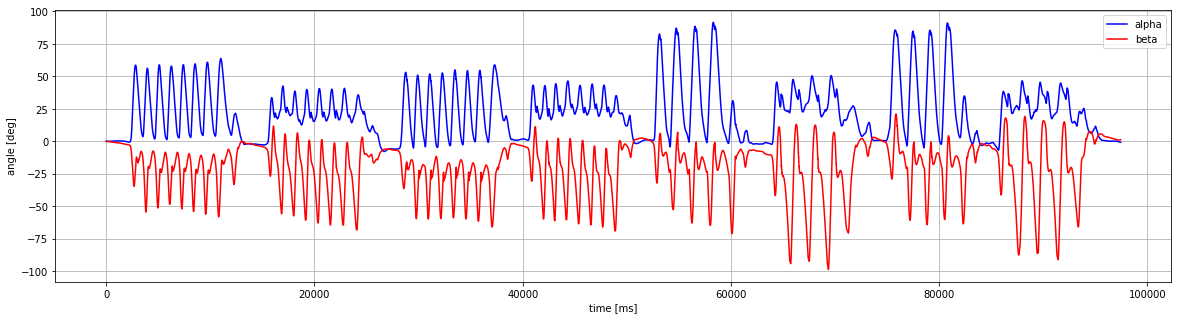

In [16]:
plt.figure(figsize=(20,5))
plt.plot(alpha, c='blue')
plt.plot(beta, c='red')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.legend(['alpha', 'beta'])
plt.grid()

> なぜこのようなグラフになるか，考えてみよ。特に，下腿の傾き角が負に出ていることを考えよ。

◼️ちなみに最初の階段降り昇り状態をプロットしてみよう：

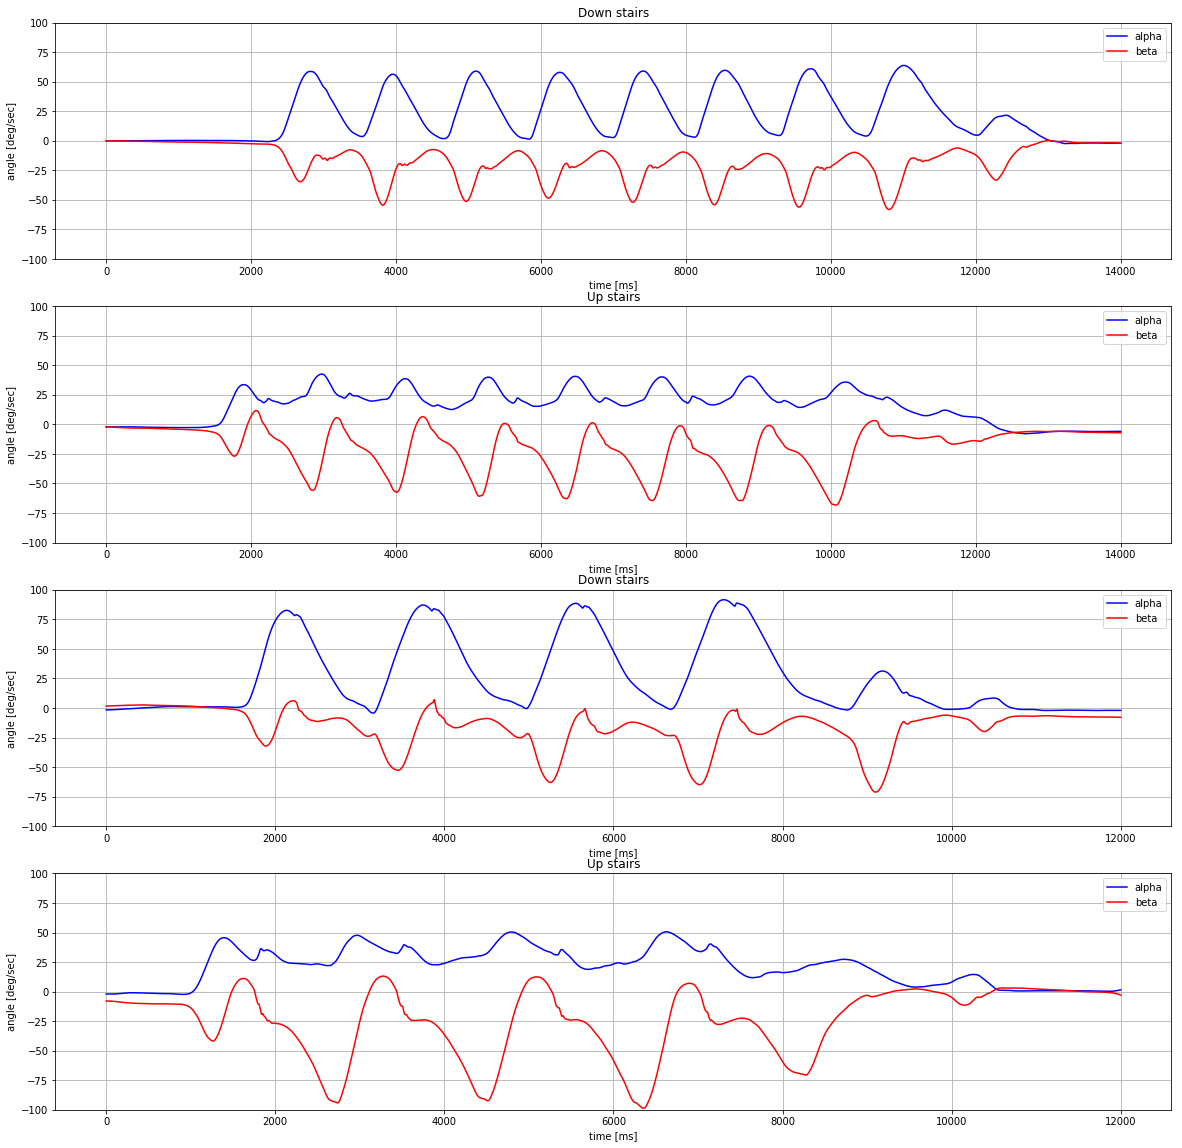

In [17]:
plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(alpha[:14000], c='blue')
plt.plot(beta[:14000], c='red')
plt.title('Down stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()   #プロット領域にグリッドをつける

plt.subplot(4, 1, 2)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(alpha[14000:28000], c='blue')
plt.plot(beta[14000:28000], c='red')
plt.title('Up stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()

plt.subplot(4, 1, 3)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(alpha[51000:63000], c='blue')
plt.plot(beta[51000:63000], c='red')
plt.title('Down stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()   #プロット領域にグリッドをつける

plt.subplot(4, 1, 4)   #パレットを2行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(alpha[63000:75000], c='blue')
plt.plot(beta[63000:75000], c='red')
plt.title('Up stairs')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg/sec]')
plt.ylim([-100, 100])
plt.legend(['alpha', 'beta'])
plt.grid()

◼️位相空間では以下のような軌跡を描く：

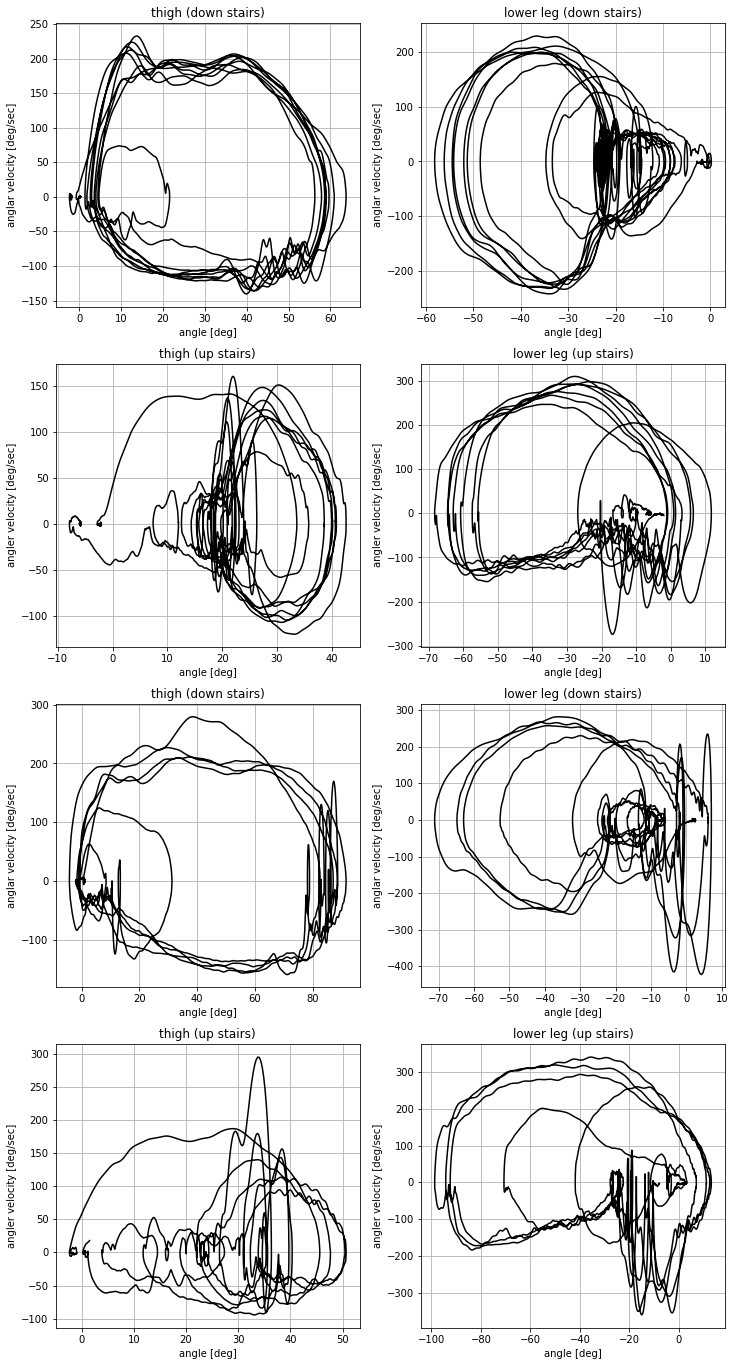

In [18]:
plt.figure(figsize=(12,24))

plt.subplot(4, 2, 1)
plt.plot(alpha[0:14000], u1_z[0:14000], c='black')
plt.title('thigh (down stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 2)
plt.plot(beta[0:14000], u2_z[0:14000],  c='black')
plt.title('lower leg (down stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 3)
plt.plot(alpha[14000:28000], u1_z[14000:28000], c='black')
plt.title('thigh (up stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 4)
plt.title('lower leg (up stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.plot(beta[14000:28000], u2_z[14000:28000],  c='black')
plt.grid()

plt.subplot(4, 2, 5)
plt.plot(alpha[51000:63000], u1_z[51000:63000], c='black')
plt.title('thigh (down stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 6)
plt.plot(beta[51000:63000], u2_z[51000:63000],  c='black')
plt.title('lower leg (down stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 7)
plt.plot(alpha[63000:75000], u1_z[63000:75000], c='black')
plt.title('thigh (up stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 8)
plt.title('lower leg (up stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.plot(beta[63000:75000], u2_z[63000:75000],  c='black')
plt.grid()

> 位相空間で１組の波形群をすべて表示すると，こんな落書きになってしまい，運動状態がまるでカオスだ。

◼️１組の波形群からティピカルな１周期分をとりだして，位相空間内の角運動の軌跡を描いてみよう：

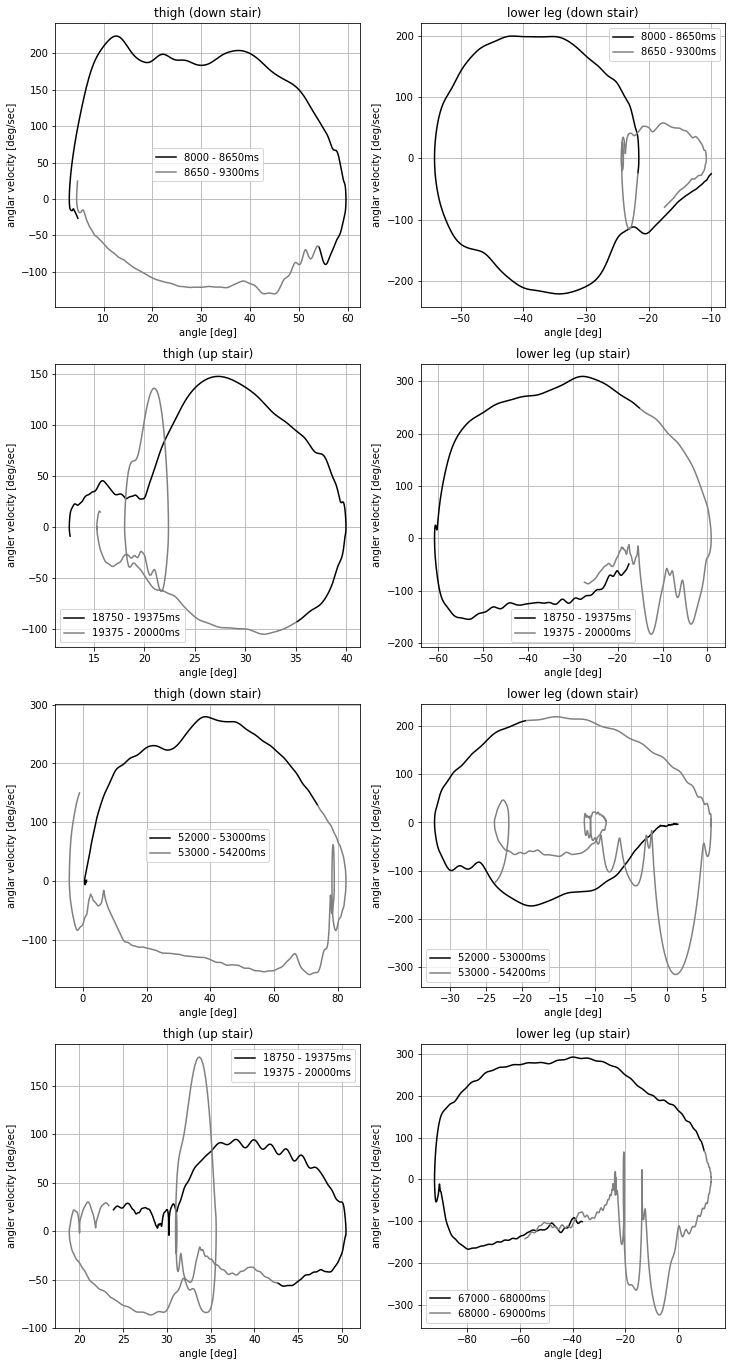

In [19]:
plt.figure(figsize=(12,24))

plt.subplot(4, 2, 1)
plt.plot(alpha[8000:8650], u1_z[8000:8650], c='black')
plt.plot(alpha[8650:9300], u1_z[8650:9300], c='gray')
plt.legend(['8000 - 8650ms', '8650 - 9300ms'])
plt.title('thigh (down stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 2)
plt.plot(beta[8000:8650], u2_z[8000:8650],  c='black')
plt.plot(beta[8650:9300], u2_z[8650:9300],  c='gray')
plt.legend(['8000 - 8650ms', '8650 - 9300ms'])
plt.title('lower leg (down stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 3)
plt.plot(alpha[18750:19375], u1_z[18750:19375], c='black')
plt.plot(alpha[19375:20000], u1_z[19375:20000], c='gray')
plt.legend(['18750 - 19375ms', '19375 - 20000ms'])
plt.title('thigh (up stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 4)
plt.plot(beta[18750:19375], u2_z[18750:19375], c='black')
plt.plot(beta[19375:20000], u2_z[19375:20000], c='gray')
plt.legend(['18750 - 19375ms', '19375 - 20000ms'])
plt.title('lower leg (up stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 5)
plt.plot(alpha[52000:53000], u1_z[52000:53000], c='black')
plt.plot(alpha[53000:54200], u1_z[53000:54200], c='gray')
plt.legend(['52000 - 53000ms', '53000 - 54200ms'])
plt.title('thigh (down stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 6)
plt.plot(beta[52000:53000], u2_z[52000:53000],  c='black')
plt.plot(beta[53000:54200], u2_z[53000:54200],  c='gray')
plt.legend(['52000 - 53000ms', '53000 - 54200ms'])
plt.title('lower leg (down stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 7)
plt.plot(alpha[67000:68000], u1_z[67000:68000], c='black')
plt.plot(alpha[68000:69000], u1_z[68000:69000], c='gray')
plt.legend(['18750 - 19375ms', '19375 - 20000ms'])
plt.title('thigh (up stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

plt.subplot(4, 2, 8)
plt.plot(beta[67000:68000], u2_z[67000:68000], c='black')
plt.plot(beta[68000:69000], u2_z[68000:69000], c='gray')
plt.legend(['67000 - 68000ms', '68000 - 69000ms'])
plt.title('lower leg (up stair)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/sec]')
plt.grid()

> 円が２つあるのは，（１周期に）二峰性の振動，つまり，１回の昇または降動作で大腿または下腿が行ったり来たり（傾いたり起きたり）しているということだ。

## ４．膝屈曲角解析

◼️大腿および下腿の単体の角運動はあまり意味がないというか，おもしろくない。君たちの興味は，膝屈曲角の角運動だと思う。いま，膝屈曲角を`theta`, 膝屈曲角速度を`omega`とすると，それらは次のように算出される：
> 大腿を固定したとすると，膝屈曲角速度を計測するためには，センサを右下腿内側（左下腿外側）に装着しなければならないことに注意せよ。

In [20]:
theta = alpha - beta
omega = u1_z - u2_z

◼️膝屈曲角と角速度をプロットしてみる：

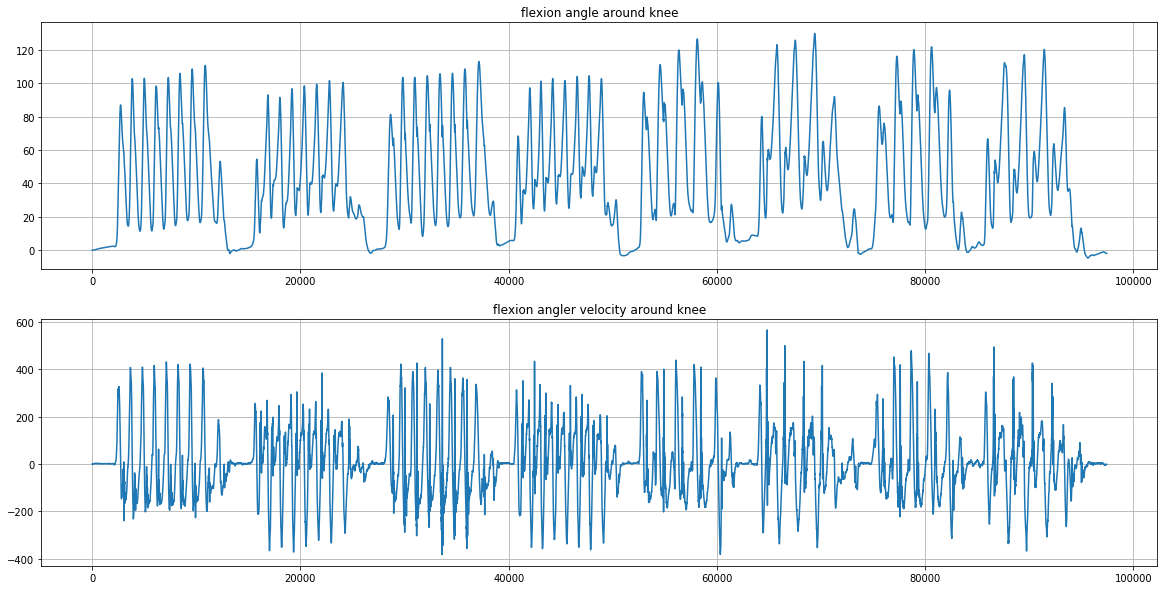

In [21]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(theta)
plt.title('flexion angle around knee')
plt.grid()

plt.subplot(2, 1, 2)   #パレットを2行1列に分割し，1行目に以下のグラフをプロットする
plt.title('flexion angler velocity around knee')
plt.plot(omega)
plt.grid()

◼️見やすくするために，最初の階段降り昇りの屈曲角および屈曲角速度をプロットしてみよう：

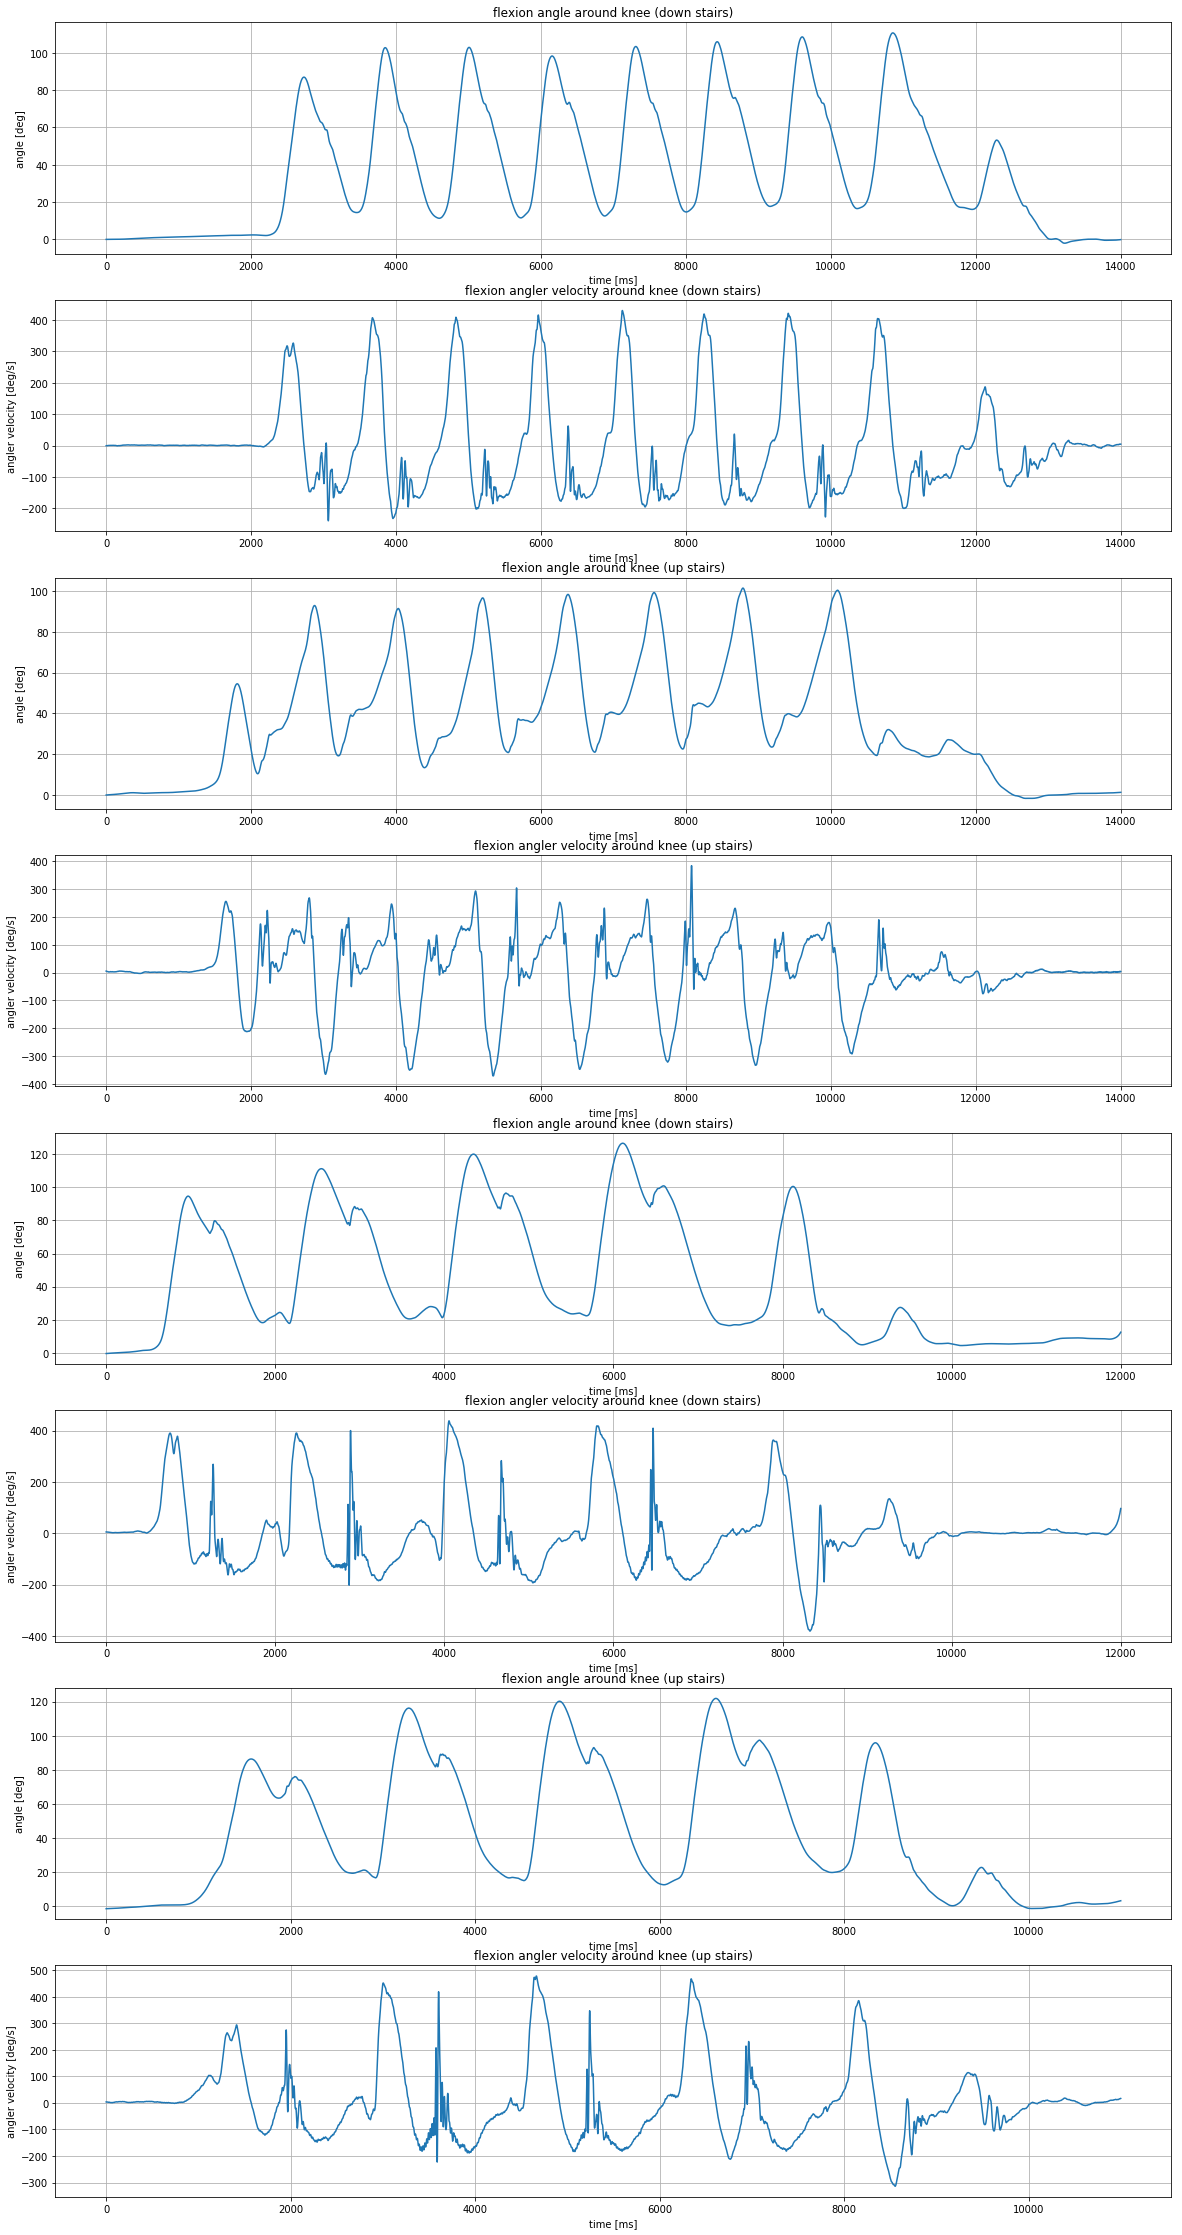

In [41]:
plt.figure(figsize=(20,40))

plt.subplot(8, 1, 1)   #パレットを8行1列に分割し，1行目に以下のグラフをプロットする
plt.plot(theta[:14000])
plt.title('flexion angle around knee (down stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 2)   #パレットを8行1列に分割し，2行目に以下のグラフをプロットする
plt.plot(omega[:14000])
plt.title('flexion angler velocity around knee (down stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(8, 1, 3)   #パレットを8行1列に分割し，3行目に以下のグラフをプロットする
plt.plot(theta[14000:28000])
plt.title('flexion angle around knee (up stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 4)   #パレットを8行1列に分割し，4行目に以下のグラフをプロットする
plt.plot(omega[14000:28000])
plt.title('flexion angler velocity around knee (up stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(8, 1, 5)   #パレットを8行1列に分割し，5行目に以下のグラフをプロットする
plt.plot(theta[52000:64000])
plt.title('flexion angle around knee (down stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 6)   #パレットを8行1列に分割し，6行目に以下のグラフをプロットする
plt.plot(omega[52000:64000])
plt.title('flexion angler velocity around knee (down stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(8, 1, 7)   #パレットを8行1列に分割し，7行目に以下のグラフをプロットする
plt.plot(theta[74000:85000])
plt.title('flexion angle around knee (up stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angle [deg]')
plt.grid()

plt.subplot(8, 1, 8)   #パレットを8行1列に分割し，8行目に以下のグラフをプロットする
plt.plot(omega[74000:85000])
plt.title('flexion angler velocity around knee (up stairs)')
plt.xlabel('time [ms]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

◼️位相空間では，膝屈曲角運動は次のような軌跡を描く：

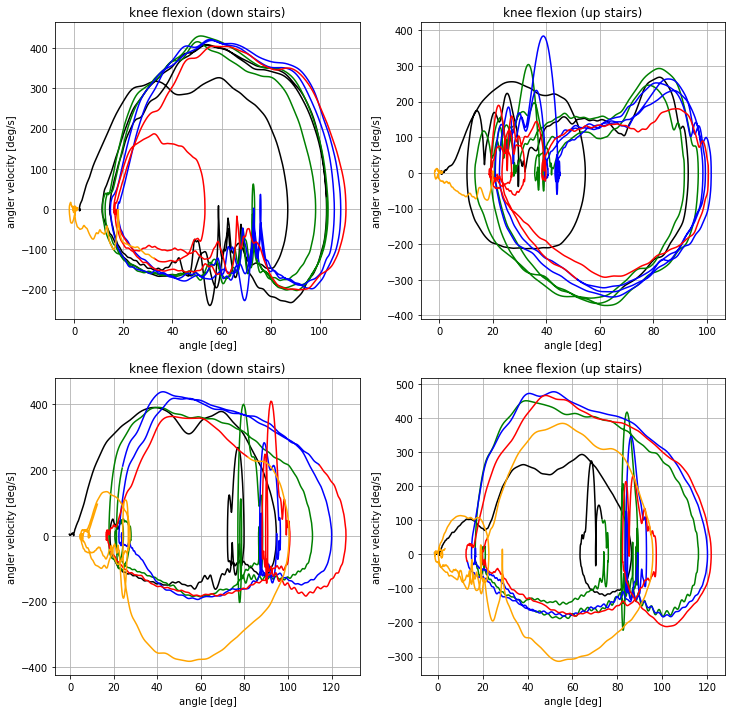

In [49]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.plot(theta[2000:5000], omega[2000:5000], c='black')
plt.plot(theta[5000:7500], omega[5000:7500], c='green')
plt.plot(theta[7500:10000], omega[7500:10000], c='blue')
plt.plot(theta[10000:12500], omega[10000:12500], c='red')
plt.plot(theta[12500:15000], omega[12500:15000], c='orange')
plt.title('knee flexion (down stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(theta[14000:17000], omega[14000:17000], c='black')
plt.plot(theta[17000:20000], omega[17000:20000], c='green')
plt.plot(theta[20000:23000], omega[20000:23000], c='blue')
plt.plot(theta[23000:26000], omega[23000:26000], c='red')
plt.plot(theta[26000:28000], omega[26000:28000], c='orange')
plt.title('knee flexion (up stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(theta[52000:54000], omega[52000:54000], c='black')
plt.plot(theta[54000:56000], omega[54000:56000], c='green')
plt.plot(theta[56000:58000], omega[56000:58000], c='blue')
plt.plot(theta[58000:60000], omega[58000:60000], c='red')
plt.plot(theta[60000:64000], omega[60000:64000], c='orange')
plt.title('knee flexion (down stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(theta[74000:76000], omega[74000:76000], c='black')
plt.plot(theta[76000:78000], omega[76000:78000], c='green')
plt.plot(theta[78000:80000], omega[78000:80000], c='blue')
plt.plot(theta[80000:82000], omega[80000:82000], c='red')
plt.plot(theta[82000:85000], omega[82000:85000], c='orange')
plt.title('knee flexion (up stairs)')
plt.xlabel('angle [deg]')
plt.ylabel('angler velocity [deg/s]')
plt.grid()


◼️１組の波形群からティピカルな１周期分をとりだして，位相空間内の膝屈曲角運動の軌跡を描いてみよう：

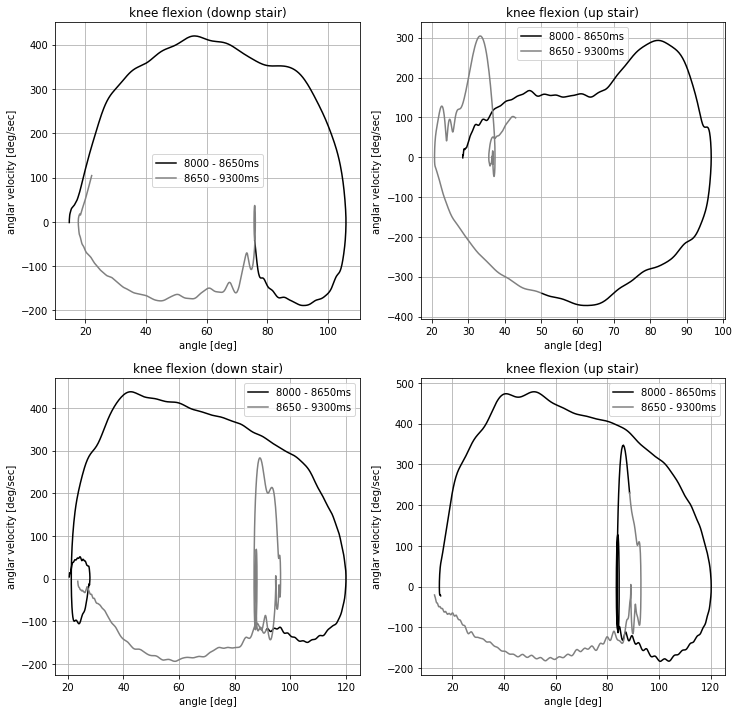

In [73]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.plot(theta[8000:8650], omega[8000:8650], c='black')
plt.plot(theta[8650:9300], omega[8650:9300], c='gray')
plt.legend(['8000 - 8650ms', '8650 - 9300ms'])
plt.title('knee flexion (downp stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(theta[18650:19375], omega[18650:19375], c='black')
plt.plot(theta[19375:20000], omega[19375:20000], c='gray')
plt.legend(['8000 - 8650ms', '8650 - 9300ms'])
plt.title('knee flexion (up stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(theta[55600:56600], omega[55600:56600], c='black')
plt.plot(theta[56600:57500], omega[56600:57500], c='gray')
plt.legend(['8000 - 8650ms', '8650 - 9300ms'])
plt.title('knee flexion (down stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(theta[78500:79251], omega[78500:79251], c='black')
plt.plot(theta[79250:80000], omega[79250:80000], c='gray')
plt.legend(['8000 - 8650ms', '8650 - 9300ms'])
plt.title('knee flexion (up stair)')
plt.xlabel('angle [deg]')
plt.ylabel('anglar velocity [deg/sec]')
plt.grid()